In [7]:
# https://github.com/Joseph94m/MCMC/blob/master/MCMC.ipynb
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import seaborn


In [143]:
# import pandas as pd
import numpy as np
import pandas as pd
from sklearn.utils import shuffle


train = pd.DataFrame(pd.read_csv('trainSentences.csv'))
train = train.dropna()
x_train = train['x']
y_train = train['y']

test = pd.DataFrame(pd.read_csv('testSentences.csv'))
test = test.dropna()
# x_test = test['x']
# y_test = test['y']


x_test_features_4 = pd.read_csv('x_test_feats_4.csv')
# test: 0 and 1 same size
noSpamTest = np.sum(test['y'])

# noSpamTest = np.sum(test['y'])
# t0 = test[test['y'] == 0]
# t1 = test[test['y'] == 1]
# t0 = t0[:noSpamTest]
# t10 = pd.DataFrame(t0)
# t10 = pd.DataFrame(t1)
# t10 = shuffle(t10)
# x_test = t10['x']
# y_test = t10['y']
                             
train = pd.DataFrame()
x_train_features_4 = pd.read_csv('x_train_feats_4.csv')
x_test_features_4_raw = pd.read_csv('x_test_feats_4.csv')
train['f0'] = x_train_features_4['0']
train['f1'] = x_train_features_4['1']
train['f2'] = x_train_features_4['2']
train['f3'] = x_train_features_4['3']
train['y'] = y_train
train = shuffle(train)

obsN = len(train)//22

odev_xy_train = train.iloc[:obsN:]
odev_x_train_features_4 = train.drop(columns=['y']).iloc[:obsN:]
odev_y_train = train['y'].iloc[:obsN:]
xS = odev_x_train_features_4
yS = odev_y_train

hdev_x_train_features_4 = train.drop(columns=['y']).iloc[obsN:]
hdev_y_train =train['y'].iloc[obsN:]


n = x_test_features_4.columns[1:]
for i in n:
    test[str(i)] = x_test_features_4_raw[str(i)]


noSpamTest = np.sum(test['y'])
t0 = test[test['y'] == 0]
t1 = test[test['y'] == 1]
t0 = t0[:noSpamTest]
t10 = pd.DataFrame(t1)
t10 = t10.append(t0)
t10 = shuffle(t10)
x_test = t10['x']
y_test = t10['y']
x_test_features_4 = t10.drop(columns=['x','y'])

data=train
# data = train.drop(['y'], axis=1)


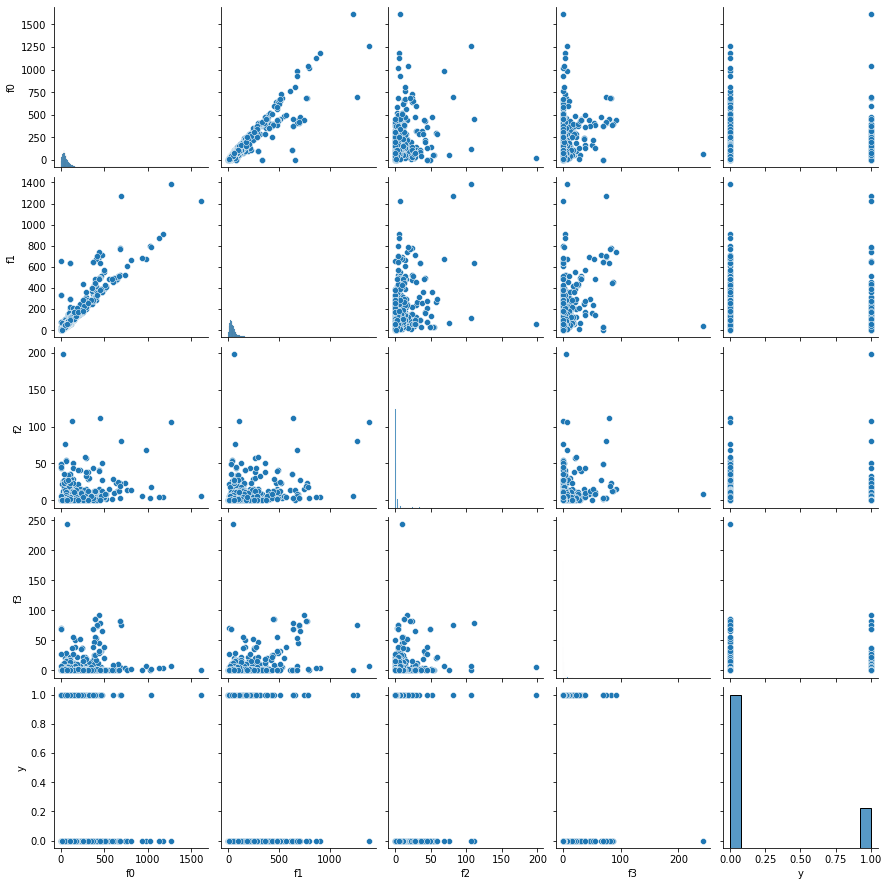

In [26]:
g = seaborn.pairplot(data)

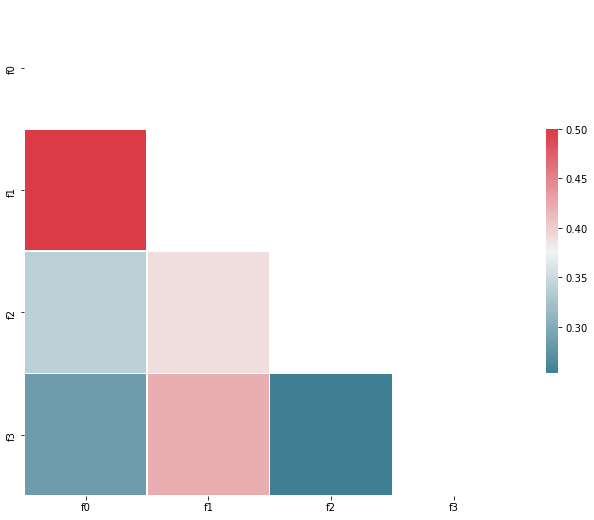

In [39]:
corr = data.drop(['y'], axis=1).corr()

# Upper tri mask
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

# fig
f,ax = plt.subplots(figsize=(11, 9))

cmap=seaborn.diverging_palette(220,10,as_cmap=True)

seaborn.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.5,
    linewidths=0.5,
    cbar_kws={'shrink':0.5},
     ax=ax,
);

In [3]:
from scipy.stats import logistic

# x is theta(x[0]=u=y_spamAvg is Real number, x[1]=s or b_scalee > 0=1?)
# transition model/proposed model/random walks: how PROPOSE SAMPLE to move from sigCurr to sigNew (wrt q's theta)
# q = lambda x:  rng.logistic(x[0], x[1] ,(2,)) # sample from pdf for log distrib p(x)
q = lambda x: logistic.rvs(x[0], x[1], (2,))

# Some value in x theta: x[0]=u=y is Real number, x[1]=scale >0 param !R-
def prior(x):
    #x[0] = mu, u mean
    #x[1] = sig (curr or new) calc
    # return 1: if all values of sigma log(1) = 0, no chagne in sum (Ratio)
    if x[1] <= 0: # pos scalar only
        return 0
    return 1

    
def sci_loglikely_logDis(x,data):
#     print(x)
    return np.sum( np.log( np.array(logistic(x[0], x[1]).pdf(data))) )  # pdf at data points
    

# Accepts or reject new sample from qposterior prospa;
def acceptence(x, x_new):
    # accept new
    if x_new >x:
        return True
    
    else:
        accept=np.random.default_rng().uniform(0,1)
        return (accept < (np.exp(x_new-x)))
    
#         return (accept < (np.exp(x_new-x)))
    
def mh(likh_comp, prior, q, param_init, iterations, data, acceptence_rule):
    #lh_Comp(x,data): return lh that theses params would gen the data
    # q(x): draws sample form sysm distrib and ret it
    # param init: starting sample , theta_i
    # data: wants to model
    # accept_rle(x,x_mew): decides new param?
    x = param_init
    accepted=[]
    rejected=[]
    
    for i in range(iterations):
        
        x_new = q(x) # new param sig new
        x_lik = likh_comp(x, data)
        x_new_lik = likh_comp(x_new, data)
        
        if (acceptence_rule( x_lik + np.log(prior(x)), x_new_lik+np.log(prior(x_new)))):
            x = x_new
            accepted.append(x_new)

        else:
            rejected.append(x_new)

    return np.array(accepted), np.array(rejected)
        


In [20]:
featNoC = 'f1'
data = xS[featNoC]
mu = np.mean(data)
iterations=2500
accepted,rejected = mh(sci_loglikely_logDis, prior, q, [0,1], iterations,data, acceptence)
accepted.shape,rejected.shape,accepted.shape[0]/iterations

<ipython-input-6-1286528ef2ab>:51: RuntimeWarning: divide by zero encountered in log
  if (acceptence_rule( x_lik + np.log(prior(x)), x_new_lik+np.log(prior(x_new)))):
<ipython-input-6-1286528ef2ab>:20: RuntimeWarning: divide by zero encountered in log
  return np.sum( np.log( np.array(logistic(x[0], x[1]).pdf(data))) )  # pdf at data points


((17, 2), (2483, 2), 0.0068)

1.086827286311528 1.4100876881411448


((1.829006031995804, 7.3957216446307665),
 (1.086827286311528, 1.4100876881411448),
 33,
 5000,
 0.0066)

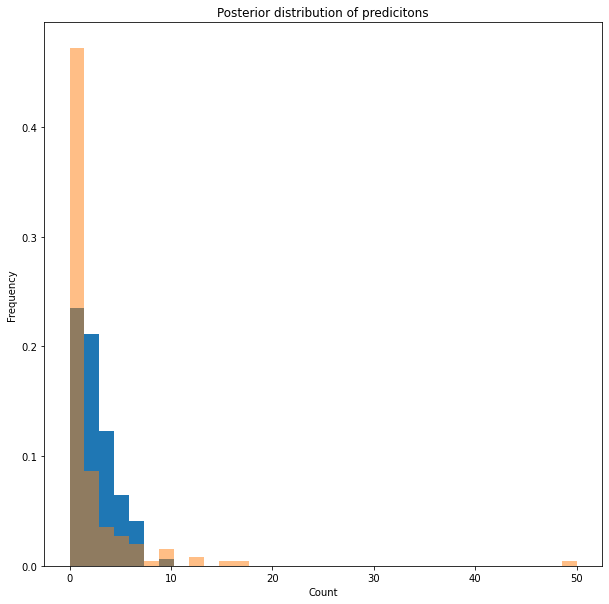

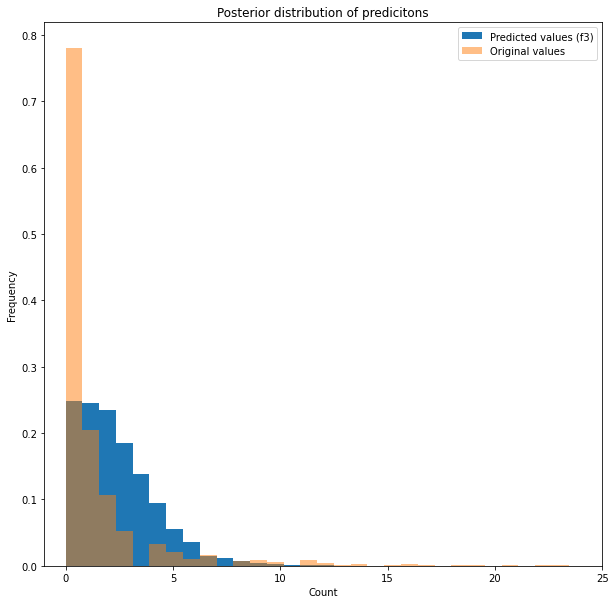

In [1201]:
if featNoC == 'f3':
    arf3 = accepted,rejected
steps = len(arf3[0])+len(arf3[1])

featNo = 'f3'
data = xS[featNo]

show=-int(0.5*arf3[0].shape[0])

mu=arf3[0][show:,0].mean()
sigma=arf3[0][show:,1].mean()
print(mu, sigma)
model = lambda t,mu,sigma:np.random.logistic(mu,sigma,t)
t=np.arange(xS[featNo].shape[0])
observation_gen=model(t.shape[0],mu,sigma)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)


# bins=np.linspace(0,75,50) 
bins=np.linspace(0,50,35) 
# bins=15
ax.hist( observation_gen , bins=bins,density=True,label="Predicted values ("+featNo+")")
ax.hist( xS[featNo] ,alpha=0.5,bins=bins,density=True, label="Original values")
ax.set_xlabel("Count")
ax.set_ylabel("Frequency")
ax.set_title("Posterior distribution of predicitons")
# ax.legend()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
data = train[featNo]
t=np.arange(train[featNo].shape[0])
observation_gen=model(t.shape[0],mu,sigma)
bins=np.linspace(0,50,65)
ax.hist( observation_gen , bins=bins,density=True,label="Predicted values ("+featNo+")")
ax.hist( train[featNo] ,alpha=0.5,bins=bins,density=True, label="Original values")
ax.set_xlabel("Count")
ax.set_ylabel("Frequency")
ax.set_title("Posterior distribution of predicitons")
ax.legend()
ax.set_xlim(-1,25)

(np.mean(data),np.std(data)),(mu, sigma), arf3[0].shape[0], steps, arf3[0].shape[0]/steps


In [1137]:
np.mean(data)

1.884393063583815

1.1238601980402831 1.4686991948810675


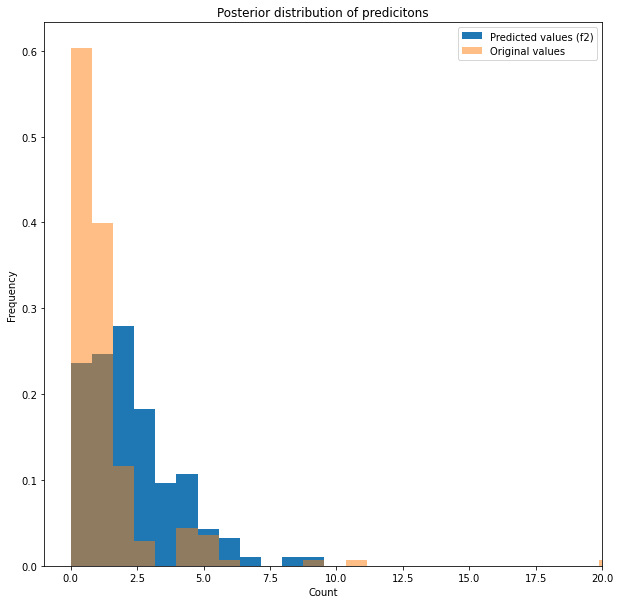

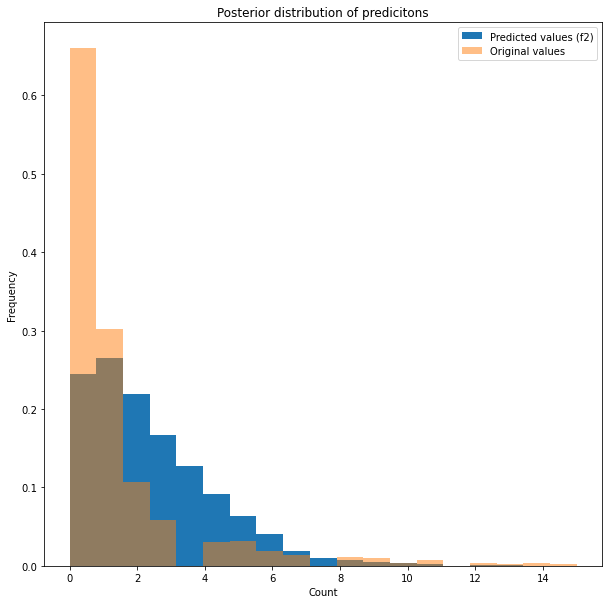

((2.016260162601626, 6.743025689925954),
 (1.1238601980402831, 1.4686991948810675),
 21,
 2500,
 0.0084)

In [1198]:
if featNoC == 'f2':
    arf2 = accepted,rejected

steps = len(arf2[0])+len(arf2[1])

featNo = 'f2'
data = xS[featNo]

show=-int(0.5*arf2[0].shape[0])

mu=arf2[0][show:,0].mean()
sigma=arf2[0][show:,1].mean()
print(mu, sigma)
model = lambda t,mu,sigma:np.random.logistic(mu,sigma,t)
# model = lambda t,mu,sigma:np.random.logistic(mu,sigma,t)
t=np.arange(data.shape[0])
observation_gen=model(t.shape[0],mu,sigma)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
# bins=np.linspace(0,1,50) 
bins=np.linspace(0,35,45)
ax.hist( observation_gen , bins=bins,density=True,label="Predicted values ("+featNo+")")
ax.hist( data ,alpha=0.5,bins=bins,density=True, label="Original values")
# ax.hist( data ,alpha=0.5,bins=bins,density=True, label="Original values")
ax.set_xlabel("Count")
ax.set_ylabel("Frequency")
ax.set_title("Posterior distribution of predicitons")
ax.legend()
ax.set_xlim(-1,max(np.max(data),np.max(observation_gen) ))
plt.show();


data = train[featNo]
t=np.arange(data.shape[0])
observation_gen=model(t.shape[0],mu,sigma)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
bins=np.linspace(0,15,20)
ax.hist( observation_gen , bins=bins,density=True,label="Predicted values ("+featNo+")")
ax.hist( data ,alpha=0.5,bins=bins,density=True, label="Original values")
# ax.hist( data ,alpha=0.5,bins=bins,density=True, label="Original values")
ax.set_xlabel("Count")
ax.set_ylabel("Frequency")
ax.set_title("Posterior distribution of predicitons")
ax.legend()
plt.show();
(np.mean(data),np.std(data)),(mu, sigma), arf2[0].shape[0], steps, arf2[0].shape[0]/steps


In [1087]:
# np.max(data, xS['f2'])

57.920231083621424 28.167977551378247


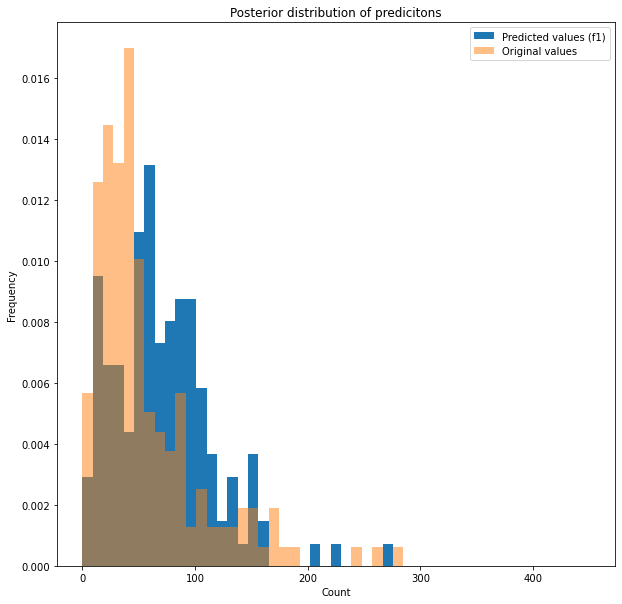

((56.23699421965318, 49.379226356733874),
 (57.920231083621424, 28.167977551378247),
 28,
 2500,
 0.0112)

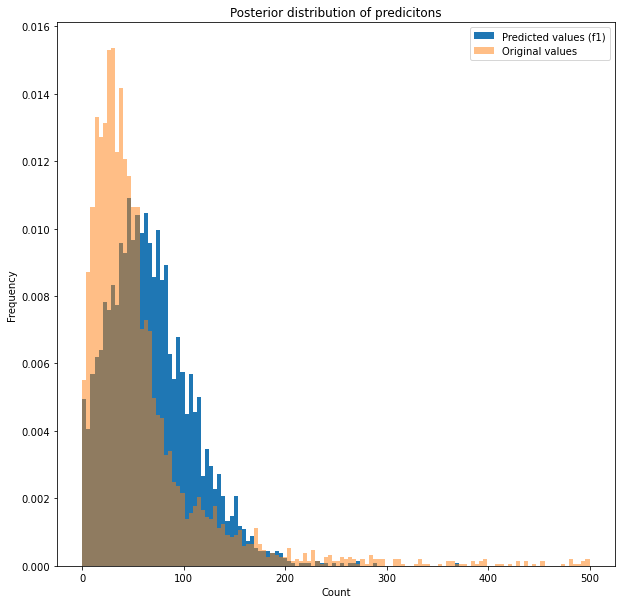

In [1177]:
if featNoC == 'f1':
    arf1 = accepted,rejected
steps = len(arf1[0])+len(arf1[1])

featNo = 'f1'
data=xS[featNo]
show=-int(0.5*accepted.shape[0])

mu=arf1[0][show:,0].mean()
sigma=arf1[0][show:,1].mean()
print(mu, sigma)
model = lambda t,mu,sigma:np.random.logistic(mu,sigma,t)

t=np.arange(xS[featNo].shape[0])
observation_gen=model(t.shape[0],mu,sigma)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation_gen,bins=np.linspace(0,450,50) ,density=True,label="Predicted values ("+featNo+")")
ax.hist( xS[featNo],bins=np.linspace(0,450,50) ,alpha=0.5,density=True, label="Original values")
ax.set_xlabel("Count")
ax.set_ylabel("Frequency")
ax.set_title("Posterior distribution of predicitons")
ax.legend()
# ax.set_xlim(-1,25)
plt.show()

data = train[featNo]
t=np.arange(data.shape[0])
observation_gen=model(t.shape[0],mu,sigma)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation_gen,bins=np.linspace(0,500,125) ,density=True,label="Predicted values ("+featNo+")")
ax.hist( train[featNo],bins=np.linspace(0,500,125),alpha=0.5,density=True, label="Original values")
ax.set_xlabel("Count")
ax.set_ylabel("Frequency")
ax.set_title("Posterior distribution of predicitons")
ax.legend()
# ax.set_xlim(-1,25)
(np.mean(xS[featNo]), np.std(xS[featNo])),(mu, sigma), arf1[0].shape[0], steps, arf1[0].shape[0]/steps




58.13166336366741 28.200966997277735


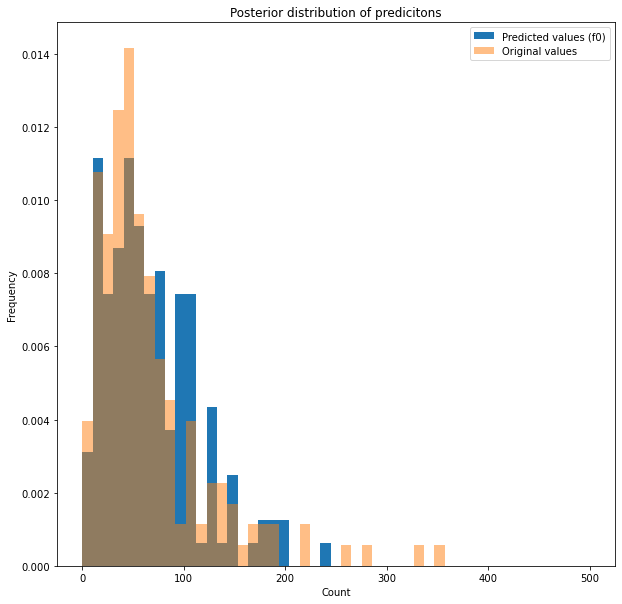

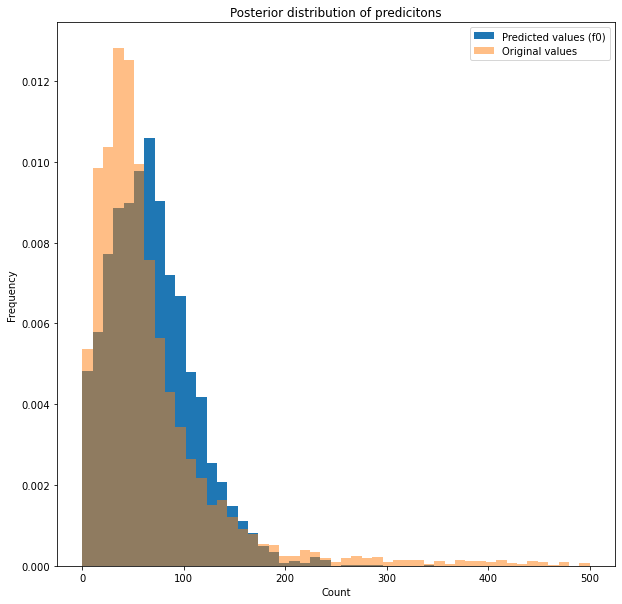

((66.61849710982659, 57.667415028964335),
 (58.13166336366741, 28.200966997277735),
 28,
 5000,
 0.0056)

In [1163]:
if featNoC == 'f0':
    arf0 = accepted,rejected
featNo = 'f0'

data = xS[featNo]
show=-int(0.5*arf0[0].shape[0])

mu=arf0[0][show:,0].mean()
sigma=arf0[0][show:,1].mean()
print(mu, sigma)
model = lambda t,mu,sigma:np.random.logistic(mu,sigma,t)
t=np.arange(data.shape[0])
observation_gen=model(t.shape[0],mu,sigma)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation_gen,bins=np.linspace(0,500,50) ,density=True,label="Predicted values ("+featNo+")")
ax.hist( data,bins=np.linspace(0,500,50) ,alpha=0.5,density=True, label="Original values")
ax.set_xlabel("Count")
ax.set_ylabel("Frequency")
ax.set_title("Posterior distribution of predicitons")
ax.legend()
plt.show()


data = train[featNo]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation_gen,bins=np.linspace(0,500,50) ,density=True,label="Predicted values ("+featNo+")")
ax.hist( data,bins=np.linspace(0,500,50) ,alpha=0.5,density=True, label="Original values")
ax.set_xlabel("Count")
ax.set_ylabel("Frequency")
ax.set_title("Posterior distribution of predicitons")
ax.legend()
plt.show()

(np.mean(xS[featNo]), np.std(xS[featNo])),(mu, sigma), arf0[0].shape[0], steps, arf0[0].shape[0]/steps

58.13166336366741 28.200966997277735


((66.61849710982659, 57.667415028964335),
 (58.13166336366741, 28.200966997277735),
 28,
 5000,
 0.0056)

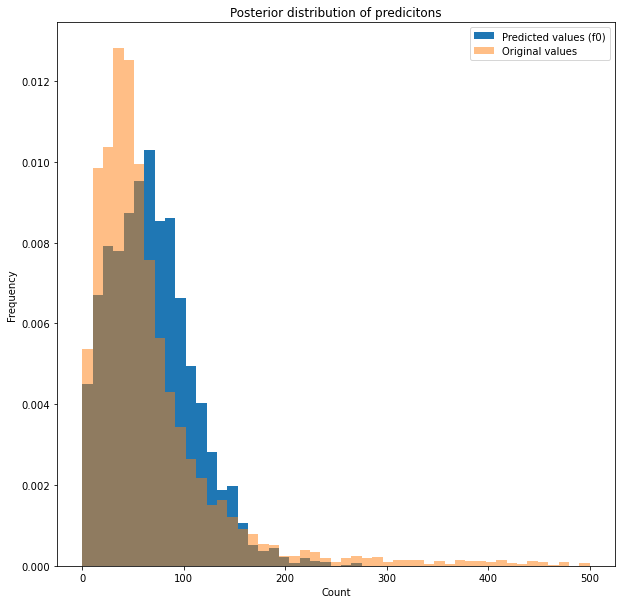

In [1162]:
if featNoC == 'f0':
    arf0 = accepted,rejected
featNo = 'f0'

data = train[featNo]
show=-int(0.5*arf0[0].shape[0])

mu=arf0[0][show:,0].mean()
sigma=arf0[0][show:,1].mean()
print(mu, sigma)
model = lambda t,mu,sigma:np.random.logistic(mu,sigma,t)
t=np.arange(data.shape[0])
observation_gen=model(t.shape[0],mu,sigma)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)



ax.hist( observation_gen,bins=np.linspace(0,500,50) ,density=True,label="Predicted values ("+featNo+")")
ax.hist( data,bins=np.linspace(0,500,50) ,alpha=0.5,density=True, label="Original values")
ax.set_xlabel("Count")
ax.set_ylabel("Frequency")
ax.set_title("Posterior distribution of predicitons")
ax.legend()
(np.mean(xS[featNo]), np.std(xS[featNo])),(mu, sigma), arf0[0].shape[0], steps, arf0[0].shape[0]/steps